Jakarta is the capital and largest city of Indonesia, a rapidly developing nation. One of their signs of development is a large public transportation network and will only continue to develop further assuming Jakarta maintains its position and increasing development after Indonesia moves their capital. One way to help improve revenue for public transportation would be to find the typical high revenue riders. For this project I attempt to predict how much money a passenger will yield based on the premises of their first check in, at least of within the month of April since that's the data I am given. Also it's important to note this is synthetic data, and couldn't find the original source.

# Import #

In [447]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
from scipy.stats import chi2_contingency
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeCV, LassoCV,ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

# Cleaning and prepping #

In [448]:
df = pd.read_csv(r"C:\Users\nicks\OneDrive\Desktop\VSprojects\Jakartatransport\dfTransjakarta.csv")

In [449]:
df.columns = map(str.lower, df.columns)
df = df.drop(['transid', 'tapoutstopsname', 'tapinstopsname'], axis=1)

In [450]:
df = df.dropna()

In [451]:
df = df.sort_values(by='tapintime')

In [452]:
df['birth_decade'] = (df['paycardbirthdate'] // 10 * 10).astype(str)

In [453]:
df['tapintime'] = pd.to_datetime(df['tapintime'])

df['tapouttime'] = pd.to_datetime(df['tapouttime'])

df['hourin'] = df['tapintime'].dt.hour.astype(str)
df['dayofweekin'] = df['tapintime'].dt.day_name()

df['hourout'] = df['tapouttime'].dt.hour.astype(str)
df['dayofweekout'] = df['tapouttime'].dt.day_name()

In [454]:
df['inbp'] = df['tapinstops'].str.contains('B').astype(int)
df['outbp'] = df['tapoutstops'].str.contains('B').astype(int)

In [455]:
df['tapinstops'] = df['tapinstops'].str.replace('[^0-9]', '', regex=True)
df['tapoutstops'] = df['tapoutstops'].str.replace('[^0-9]', '', regex=True)

In [456]:
df['tapinstops'] = (df['tapinstops'].astype(int) // 10 * 10).astype(str).str.pad(5, fillchar='0')
df['tapoutstops'] = (df['tapoutstops'].astype(int) // 10 * 10).astype(str).str.pad(5, fillchar='0')

In [457]:
most_common_tapinstops = df.groupby('paycardid')['tapinstops'].agg(lambda x: x.mode()[0]).reset_index()
most_common_tapinstops.rename(columns={'tapinstops': 'most_common_tapinstops'}, inplace=True)

df = df.merge(most_common_tapinstops, on='paycardid', how='left')

In [458]:
dfupdated = df.groupby('paycardid')['payamount'].sum()
df = df.merge(dfupdated, on='paycardid', suffixes=('', '_total'))

In [459]:
dfunique = df.drop_duplicates(subset='paycardid')

In [460]:
df

,paycardid,paycardbank,paycardname,paycardsex,paycardbirthdate,corridorid,corridorname,direction,tapinstops,tapinstopslat,tapinstopslon,stopstartseq,tapintime,tapoutstops,tapoutstopslat,tapoutstopslon,stopendseq,tapouttime,payamount,birth_decade,hourin,dayofweekin,hourout,dayofweekout,inbp,outbp,most_common_tapinstops,payamount_total
0,213107623841273,emoney,Natalia Pratama,M,1964,11D,Pulo Gebang - Pulo Gadung 2 via PIK,0.0,05820,-6.183260,106.93243,28,2023-04-01 06:22:27,03090,-6.183068,106.93194,29.0,2023-04-01 08:15:45,3500.0,1960,6,Saturday,8,Saturday,1,1,05820,3500.0
1,4139531858845,online,Tgk. Kacung Nashiruddin,F,1997,7E,Kampung Rambutan - Ragunan,1.0,01060,-6.301222,106.83623,7,2023-04-01 06:54:35,03140,-6.308410,106.87071,15.0,2023-04-01 07:27:31,3500.0,1990,6,Saturday,7,Saturday,1,1,01060,3500.0
2,60459139923,flazz,Zelda Thamrin,M,1972,JIS3,Harmoni - Jakarta International Stadium,0.0,00040,-6.146869,106.85805,8,2023-04-01 07:32:50,00160,-6.167710,106.82819,12.0,2023-04-01 08:16:02,3500.0,1970,7,Saturday,8,Saturday,0,0,00040,3500.0
3,4301046448643115806,brizzi,Rama Firmansyah,F,1992,5C,PGC - Juanda,0.0,00010,-6.257751,106.87000,1,2023-04-01 09:41:03,00030,-6.250309,106.87360,2.0,2023-04-01 10:27:36,3500.0,1990,9,Saturday,10,Saturday,0,0,00010,3500.0
4,4558067111007925,dki,Faizah Lailasari,M,1989,7B,Kampung Rambutan - Blok M,0.0,00200,-6.284664,106.87123,15,2023-04-01 12:35:29,00250,-6.261889,106.86423,22.0,2023-04-01 14:16:26,3500.0,1980,12,Saturday,14,Saturday,1,1,00200,3500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31725,3552701702810473,dki,Ir. Kartika Aryani,F,2009,JAK.45,Lebak Bulus - Ragunan,0.0,02020,-6.303426,106.79914,20,2023-04-30 15:48:29,01710,-6.310604,106.80571,33.0,2023-04-30 16:18:39,0.0,2000,15,Sunday,16,Sunday,1,1,02020,0.0
31726,4839065457731638,dki,Leo Wastuti,F,1991,2P,Gondangdia - Senen,0.0,00180,-6.186792,106.83514,2,2023-04-30 17:04:56,05810,-6.181662,106.83288,6.0,2023-04-30 18:10:48,3500.0,1990,17,Sunday,18,Sunday,1,1,00180,3500.0
31727,561500422432,flazz,"Sabrina Megantara, M.Farm",F,2007,10A,Rusun Marunda - Tanjung Priok,0.0,05070,-6.100212,106.96060,2,2023-04-30 17:08:35,00050,-6.110150,106.89242,6.0,2023-04-30 19:48:13,0.0,2000,17,Sunday,19,Sunday,1,0,05070,0.0
31728,4219617295377842342,brizzi,"Ir. Hesti Fujiati, S.T.",F,1997,1R,Senen - Tanah Abang,1.0,05860,-6.169862,106.83936,14,2023-04-30 20:05:53,05720,-6.173560,106.84213,15.0,2023-04-30 21:00:42,3500.0,1990,20,Sunday,21,Sunday,1,1,05860,3500.0


# Analyze #

In [461]:
from sklearn.model_selection import train_test_split
dfchoose = df[['paycardbank', 'paycardsex', 'birth_decade', 'hourin', 'dayofweekin', 'inbp', 'payamount_total']]


x = dfchoose.drop('payamount_total', axis = 1)
y = dfchoose['payamount_total']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

In [462]:
x_trainy = x_train.join(y_train)


### Bank ###

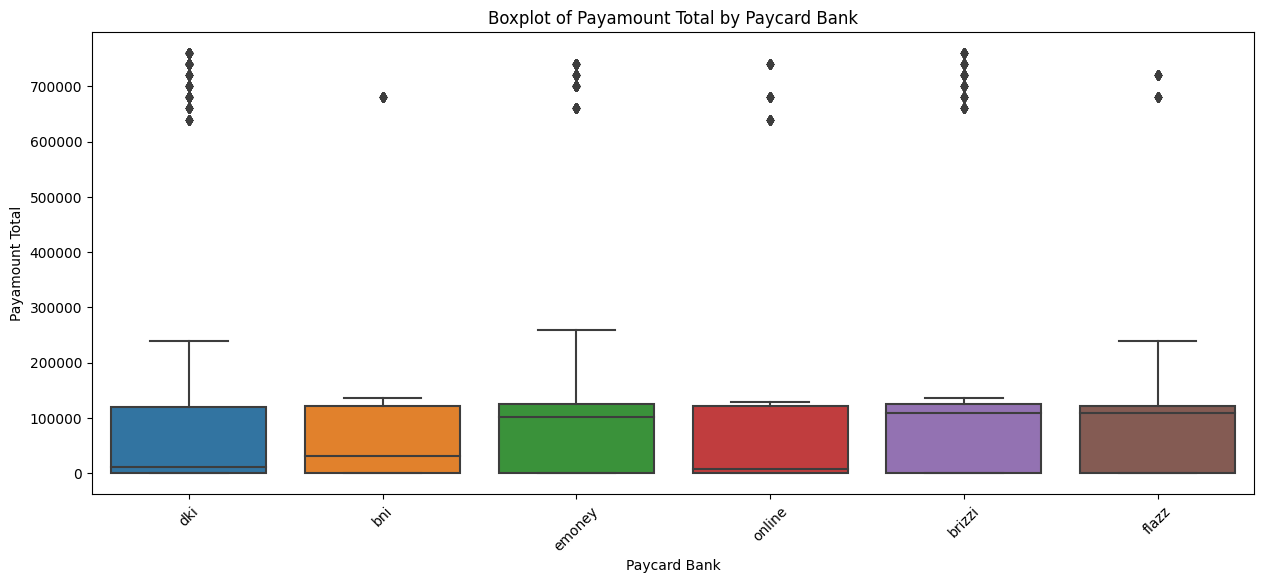

In [463]:
order = ['dki', 'bni', 'emoney', 'online', 'brizzi', 'flazz']
plt.figure(figsize=(15,6))
sns.boxplot(x='paycardbank', y='payamount_total', data=x_trainy, order = order)
plt.xticks(rotation=45)
plt.xlabel('Paycard Bank')
plt.ylabel('Payamount Total')
plt.title('Boxplot of Payamount Total by Paycard Bank')
plt.show()

c:\Users\nicks\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x600 with 0 Axes>

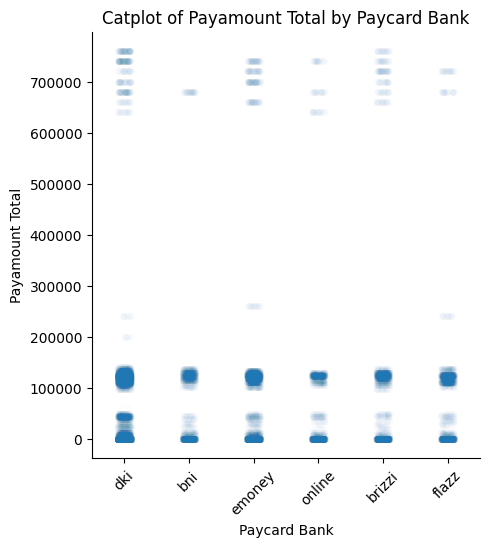

In [464]:
plt.figure(figsize=(15,6))
sns.catplot(x='paycardbank', y='payamount_total', data=x_trainy, alpha = 0.01, order = order)
plt.xticks(rotation=45)
plt.xlabel('Paycard Bank')
plt.ylabel('Payamount Total')
plt.title('Catplot of Payamount Total by Paycard Bank')
plt.show()

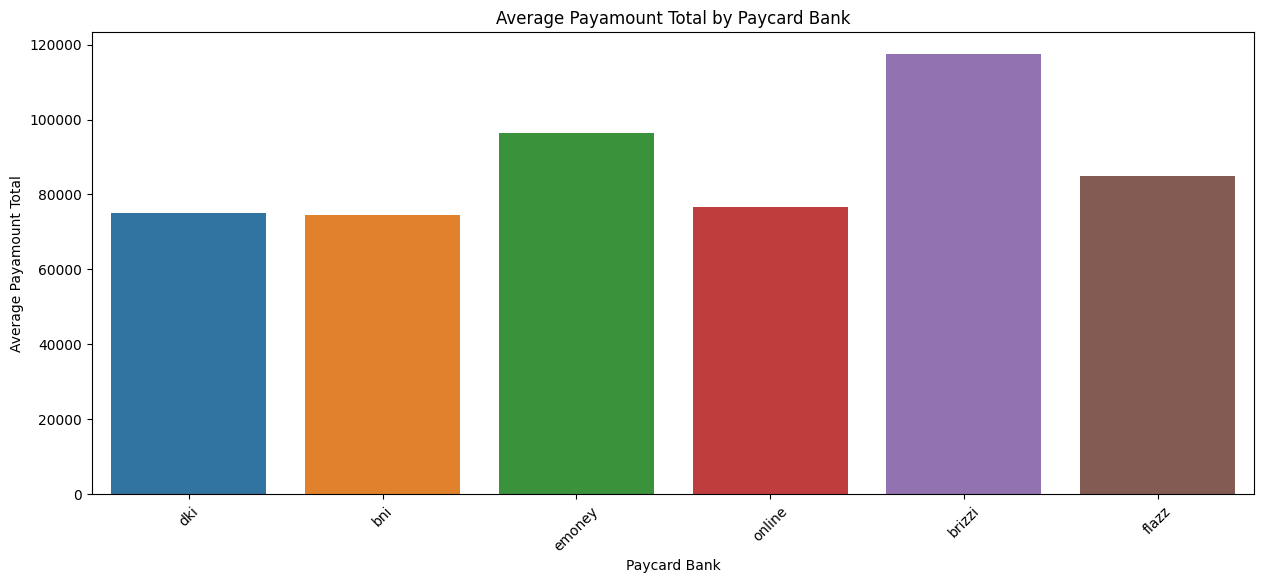

In [465]:
bank_avg_payamount = x_trainy.groupby('paycardbank')['payamount_total'].mean()

plt.figure(figsize=(15,6))
sns.barplot(x=bank_avg_payamount.index, y=bank_avg_payamount.values, order = order)
plt.xticks(rotation=45)
plt.xlabel('Paycard Bank')
plt.ylabel('Average Payamount Total')
plt.title('Average Payamount Total by Paycard Bank')
plt.show()

It appears the brzzi users tend to pay the most. Amusingly enough the top and bottom quartiles are all equivalent. I have zero idea which bank is which in the sense of whether it's something respected like Charles Schwab or less so like Robinhood. Most interesting however is there is a huge gap between the upper quartile and outlier group, it's basically the riders are either whales or they're not, no in between. Another interesting bit is there is serious concentration at the quartiles. I have some suspicion it has something to do with the synthesizing nature of data.

### Gender ###

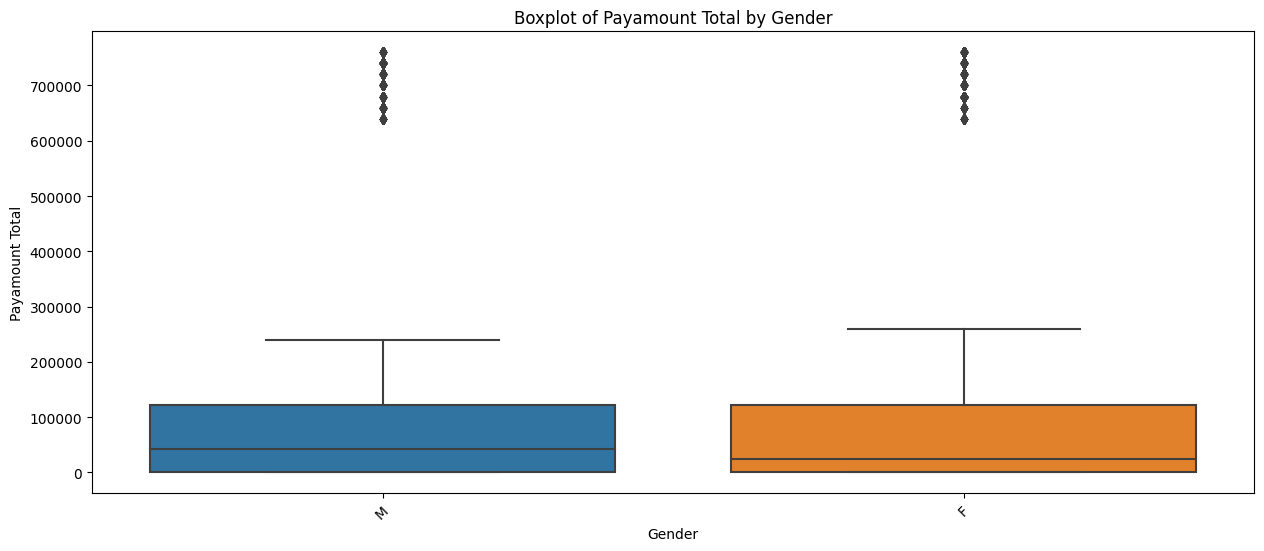

In [466]:
order = ['M', 'F']
plt.figure(figsize=(15,6))
sns.boxplot(x='paycardsex', y='payamount_total', data=x_trainy, order = order)
plt.xticks(rotation=45)
plt.xlabel('Gender')
plt.ylabel('Payamount Total')
plt.title('Boxplot of Payamount Total by Gender')
plt.show()

c:\Users\nicks\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x600 with 0 Axes>

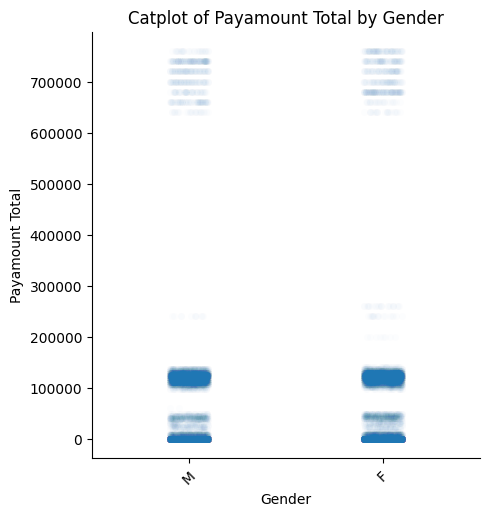

In [467]:
plt.figure(figsize=(15,6))
sns.catplot(x='paycardsex', y='payamount_total', data=x_trainy, alpha = 0.01, order = order)
plt.xticks(rotation=45)
plt.xlabel('Gender')
plt.ylabel('Payamount Total')
plt.title('Catplot of Payamount Total by Gender')
plt.show()

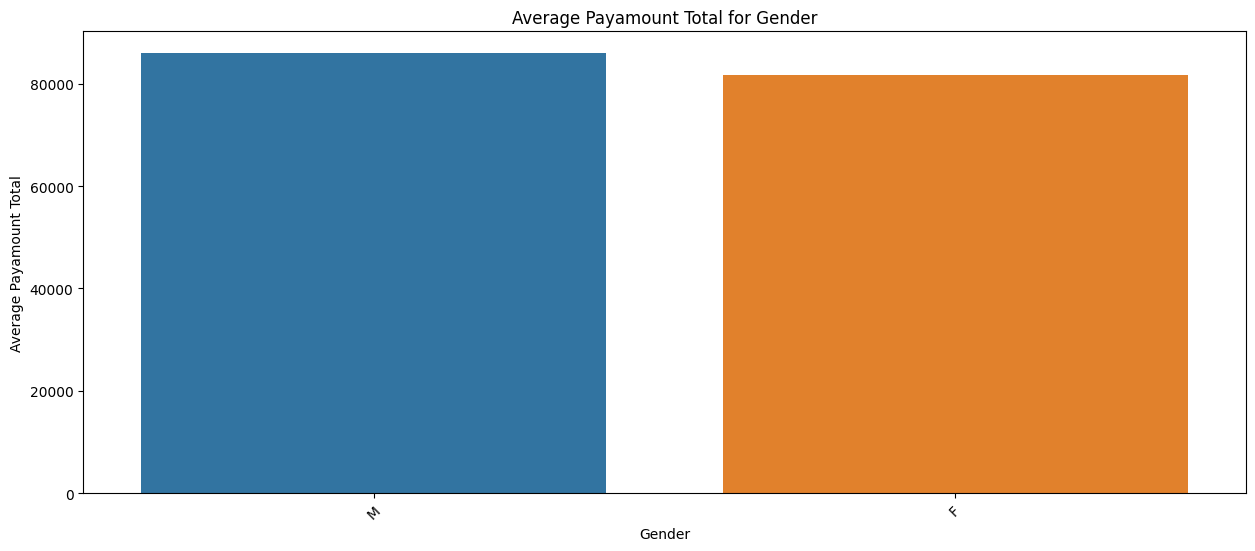

In [468]:
bank_avg_payamount = x_trainy.groupby('paycardsex')['payamount_total'].mean()

plt.figure(figsize=(15,6))
sns.barplot(x=bank_avg_payamount.index, y=bank_avg_payamount.values, order = order)
plt.xticks(rotation=45)
plt.xlabel('Gender')
plt.ylabel('Average Payamount Total')
plt.title('Average Payamount Total for Gender')
plt.show()

Average payment by gender is more or less the same, however there appears to be some more women between the 

### Birth year ###

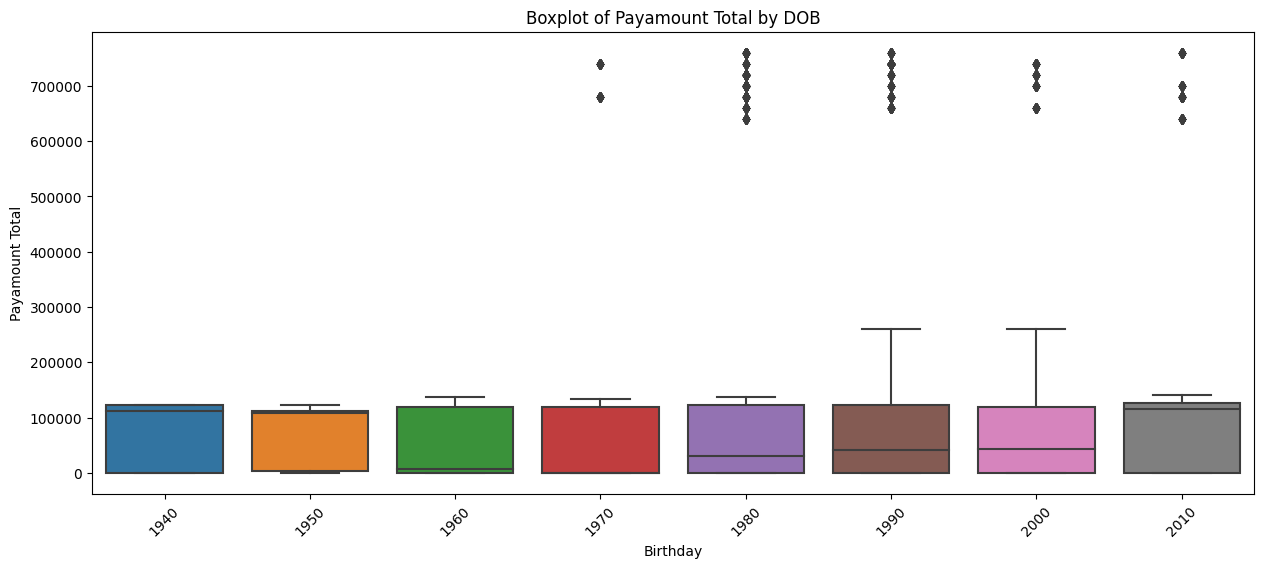

In [469]:
order = ['1940', '1950', '1960', '1970', '1980', '1990', '2000', '2010']
plt.figure(figsize=(15,6))
sns.boxplot(x='birth_decade', y='payamount_total', data=x_trainy, order = order)
plt.xticks(rotation=45)
plt.xlabel('Birthday')
plt.ylabel('Payamount Total')
plt.title('Boxplot of Payamount Total by DOB')
plt.show()

c:\Users\nicks\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x600 with 0 Axes>

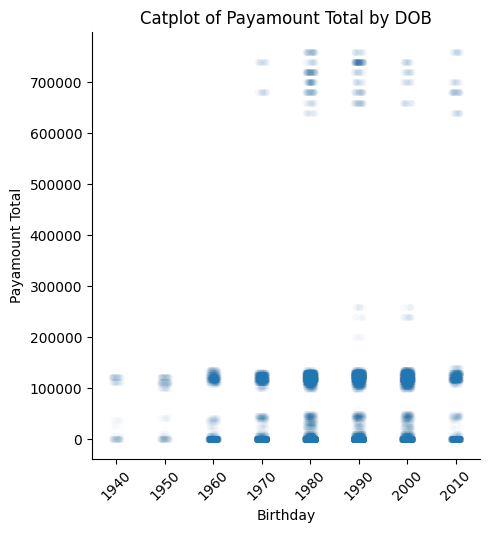

In [470]:
plt.figure(figsize=(15,6))
sns.catplot(x='birth_decade', y='payamount_total', data=x_trainy, alpha = 0.01, order = order)
plt.xticks(rotation=45)
plt.xlabel('Birthday')
plt.ylabel('Payamount Total')
plt.title('Catplot of Payamount Total by DOB')
plt.show()

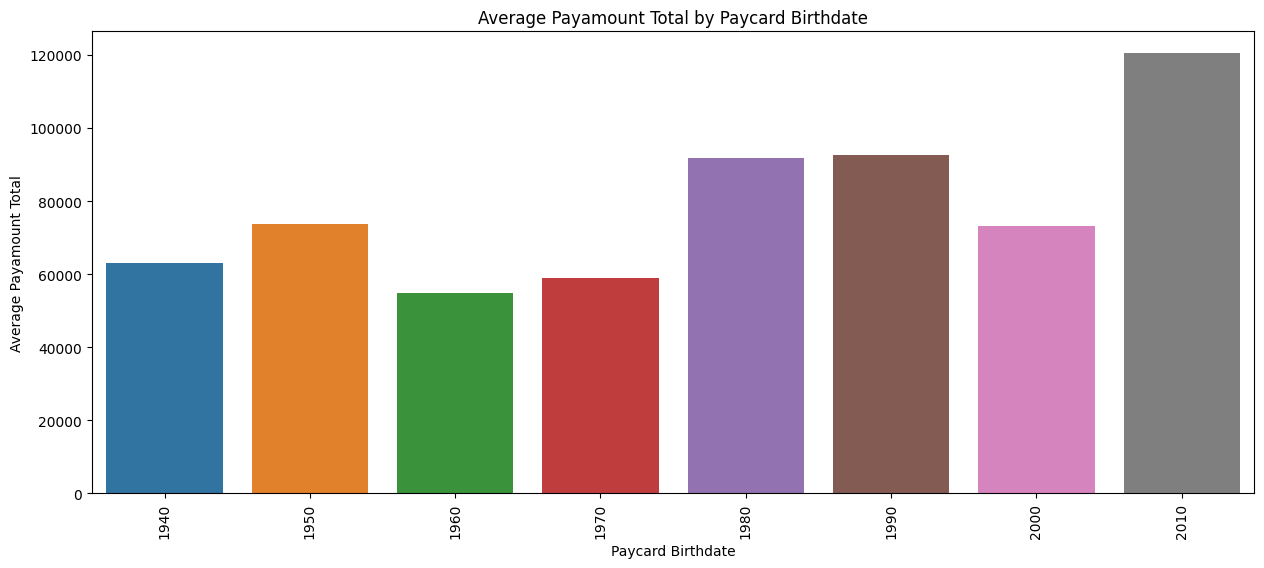

In [471]:
birthdate_avg_payamount = x_trainy.groupby('birth_decade')['payamount_total'].mean()

# Plotting
plt.figure(figsize=(15,6))
sns.barplot(x=birthdate_avg_payamount.index, y=birthdate_avg_payamount.values, order = order)
plt.xticks(rotation=90)
plt.xlabel('Paycard Birthdate')
plt.ylabel('Average Payamount Total')
plt.title('Average Payamount Total by Paycard Birthdate')
plt.show()

It appears the  young ones spend the most, which makes sense since they aren't of age to be able to drive a car. The 20 and 30 year olds are also big spenders which I'd imagine because they can drive, but they can't afford the cars not to mention they have families to support.

### Hour ###

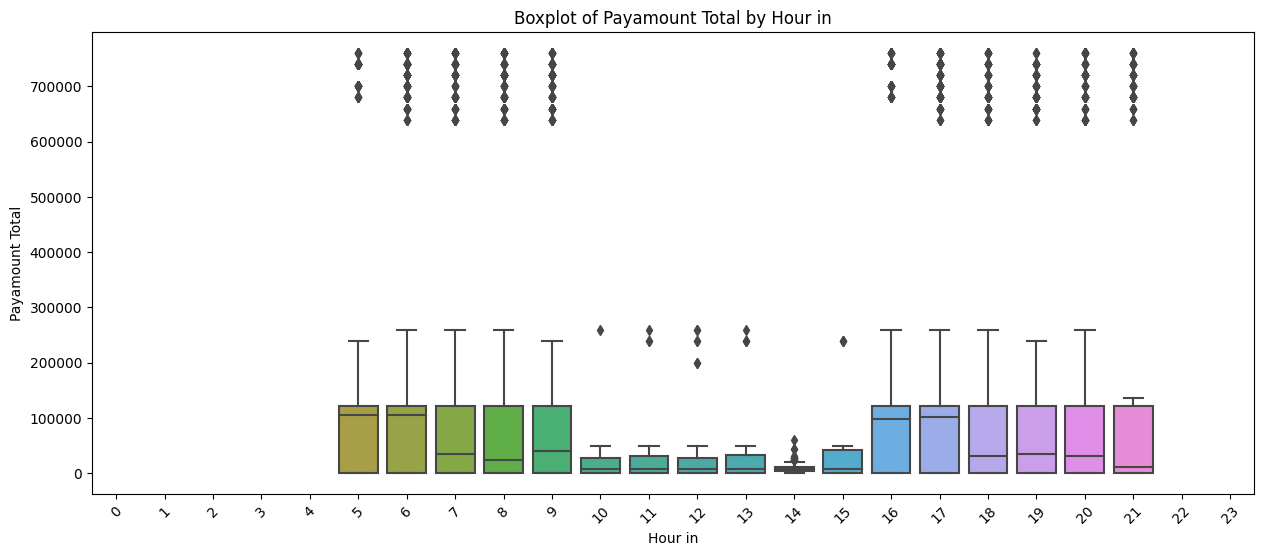

In [472]:
order = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']

plt.figure(figsize=(15,6))
sns.boxplot(x='hourin', y='payamount_total', data=x_trainy, order = order)
plt.xticks(rotation=45)
plt.xlabel('Hour in')
plt.ylabel('Payamount Total')
plt.title('Boxplot of Payamount Total by Hour in')
plt.show()

c:\Users\nicks\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x600 with 0 Axes>

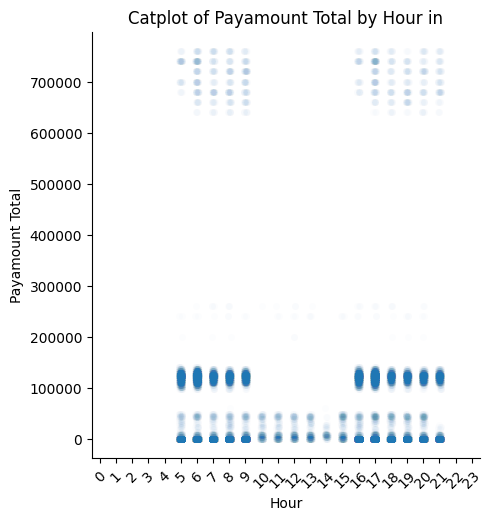

In [473]:
plt.figure(figsize=(15,6))
sns.catplot(x='hourin', y='payamount_total', data=x_trainy, alpha = 0.01, order = order)
plt.xticks(rotation=45)
plt.xlabel('Hour')
plt.ylabel('Payamount Total')
plt.title('Catplot of Payamount Total by Hour in')
plt.show()

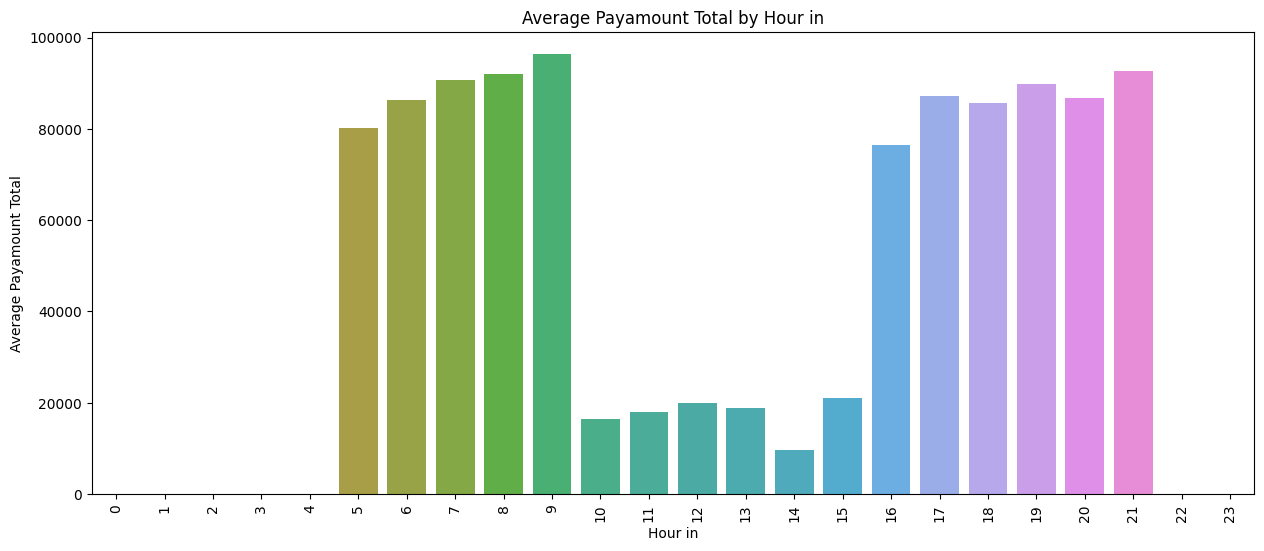

In [474]:
birthdate_avg_payamount = x_trainy.groupby('hourin')['payamount_total'].mean()


plt.figure(figsize=(15,6))
sns.barplot(x=birthdate_avg_payamount.index, y=birthdate_avg_payamount.values, order = order)
plt.xticks(rotation=90)
plt.xlabel('Hour in')
plt.ylabel('Average Payamount Total')
plt.title('Average Payamount Total by Hour in')
plt.show()

First thing that can be noticed is that there's a gap of time where there's no service indicating that public transport is closed these hours, and those that did their first tap in of the month are those in the rush hours. I'd imagine there's some kind of pricing which gives discount in the valley hours, similar to NS daluren in the Netherlands

### Weekday ###

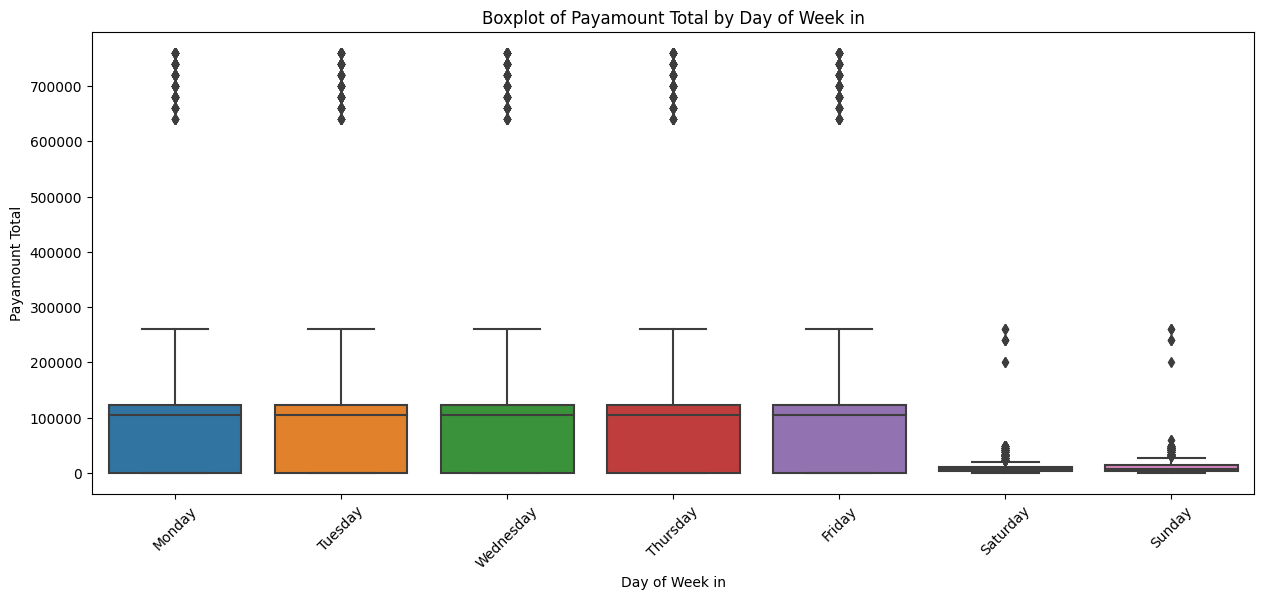

In [475]:
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(15,6))
sns.boxplot(x='dayofweekin', y='payamount_total', data=x_trainy, order=order)
plt.xticks(rotation=45)
plt.xlabel('Day of Week in')
plt.ylabel('Payamount Total')
plt.title('Boxplot of Payamount Total by Day of Week in')
plt.show()

c:\Users\nicks\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x600 with 0 Axes>

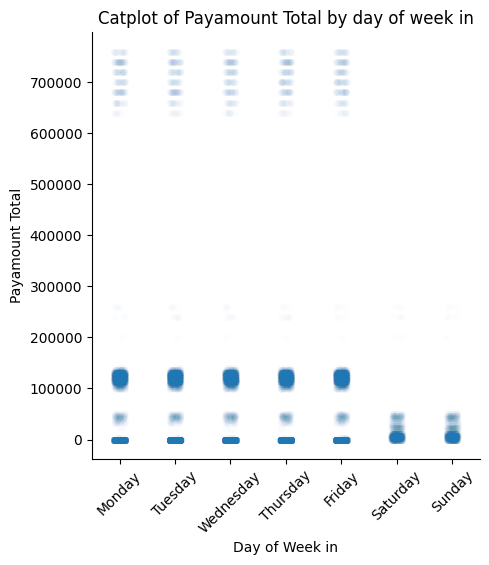

In [476]:
plt.figure(figsize=(15,6))
sns.catplot(x='dayofweekin', y='payamount_total', data=x_trainy, alpha = 0.01, order = order)
plt.xticks(rotation=45)
plt.xlabel('Day of Week in')
plt.ylabel('Payamount Total')
plt.title('Catplot of Payamount Total by day of week in')
plt.show()

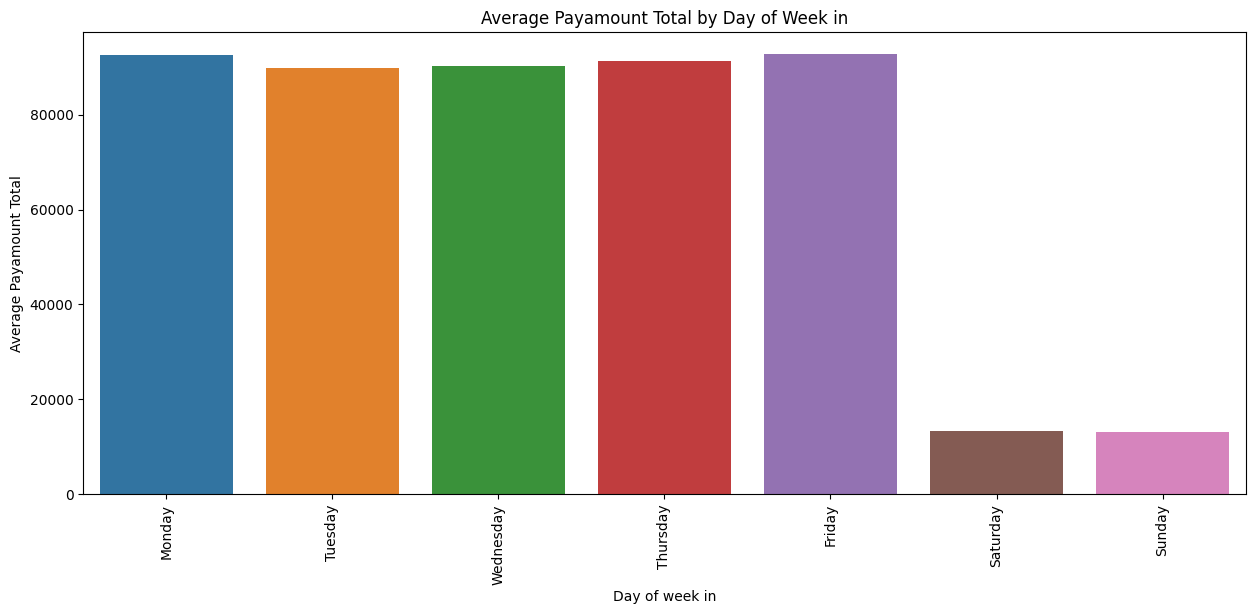

In [477]:
birthdate_avg_payamount = x_trainy.groupby('dayofweekin')['payamount_total'].mean()
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# Plotting
plt.figure(figsize=(15,6))
sns.barplot(x=birthdate_avg_payamount.index, y=birthdate_avg_payamount.values, order = order)
plt.xticks(rotation=90)
plt.xlabel('Day of week in')
plt.ylabel('Average Payamount Total')
plt.title('Average Payamount Total by Day of Week in')
plt.show()

More payers in weekdays, nothing surprising. Basically the time when business happens.

In [478]:
# Function for pvalues of categorical relations
def categorical_relationship(data):
    for col in data.columns:

        contingency_table = pd.crosstab(data[col], data['payamount_total'])
        

        chi2, p, dof, expected = chi2_contingency(contingency_table)

        
        print('-----------------------')
        print(col)
        print(p)

In [479]:
x_trainencode = pd.get_dummies(x_train, columns = ['paycardbank', 'paycardsex', 'birth_decade', 'hourin', 'dayofweekin', 'inbp'], dtype = 'float32')
x_testencode = pd.get_dummies(x_test, columns = ['paycardbank', 'paycardsex', 'birth_decade', 'hourin', 'dayofweekin', 'inbp'], dtype = 'float32')
print(len(x_trainencode.columns))

42


In [480]:
x_trainencodey = x_trainencode.join(y_train)

categorical_relationship(x_trainencodey)

-----------------------
paycardbank_bni
1.528041538275141e-114
-----------------------
paycardbank_brizzi
3.1344254773554666e-103
-----------------------
paycardbank_dki
3.004168649528769e-114
-----------------------
paycardbank_emoney
4.861847101633887e-174
-----------------------
paycardbank_flazz
1.0309670122734621e-159
-----------------------
paycardbank_online
2.0017087369276552e-98
-----------------------
paycardsex_F
5.704986385416079e-75
-----------------------
paycardsex_M
5.704986385416079e-75
-----------------------
birth_decade_1940
3.182372143274075e-60
-----------------------
birth_decade_1950
4.0082513901821687e-147
-----------------------
birth_decade_1960
1.331943558214212e-61
-----------------------
birth_decade_1970
6.84102613678757e-82
-----------------------
birth_decade_1980
1.8704706590941947e-91
-----------------------
birth_decade_1990
3.1842360602042688e-121
-----------------------
birth_decade_2000
3.966304463250176e-85
-----------------------
birth_decade_20

In case you were wondering, yes they are all quite statistically significant, very significant.

# Neural Network #

We'll use Neural networks to predict the total payment of the conditions during the first purchase made. 


A Neural network is an ML method which basically is a web of nodes in layers to predict an outcome. NNs can be visualized by 3 layers; input, output, and hidden. The input layer is as the name suggests, the starting point of the neural network where the values are taken in. The amount of nodes for the input layer is typically the amount of variables. The next part is the hidden layer. Hidden layers can have one or many layers, typically depending on the complexity of the data, but for this project, 1 or 2 is sufficient. The hidden layer takes the values from the input layer, and does the magic of finding relations of the variables and will then pass it on to the next hidden layer or the output. The output layer is the final part which will give the result, and in this case, a single continuous number.

For this network we'll be using 36 neurons for the first layer, each representing a variable and another 36 for the second layer, same reason given, with the output layer being just one neuron.

For the second NN we'll be adding another layer with 3 neurons to account for the noticable payment clusters observed in the data; the whales, the normal, and the non-spenders.

In [481]:
s_scaler = StandardScaler()
x_trainencode = s_scaler.fit_transform(x_trainencode)
x_testencode = s_scaler.fit_transform(x_testencode)

In [482]:
model = Sequential()
model.add(Dense(36,activation='relu'))
model.add(Dense(36,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='Adam',loss='mse')

In [483]:
model.fit(x=x_trainencode,y=y_train,
          validation_data=(x_testencode,y_test),
          batch_size=128,epochs=400)

Epoch 1/400
199/199 [==============================] - 1s 2ms/step - loss: 27520417792.0000 - val_loss: 28263825408.0000
Epoch 2/400
199/199 [==============================] - 0s 2ms/step - loss: 27447728128.0000 - val_loss: 28111636480.0000
Epoch 3/400
199/199 [==============================] - 0s 2ms/step - loss: 27175948288.0000 - val_loss: 27695927296.0000
Epoch 4/400
199/199 [==============================] - 0s 2ms/step - loss: 26604648448.0000 - val_loss: 26951307264.0000
Epoch 5/400
199/199 [==============================] - 0s 2ms/step - loss: 25711159296.0000 - val_loss: 25902583808.0000
Epoch 6/400
199/199 [==============================] - 0s 2ms/step - loss: 24554588160.0000 - val_loss: 24647878656.0000
Epoch 7/400
199/199 [==============================] - 0s 2ms/step - loss: 23276752896.0000 - val_loss: 23354703872.0000
Epoch 8/400
199/199 [==============================] - 0s 2ms/step - loss: 22059241472.0000 - val_loss: 22211559424.0000
Epoch 9/400
199/199 [===========

In [484]:
from sklearn import metrics
y_pred = model.predict(x_testencode)

print('VarScore:',metrics.explained_variance_score(y_test,y_pred))

199/199 [==============================] - 0s 947us/step
VarScore: 0.15749324125237552


Result accuracy typically fall in the .1-.2

In [485]:
model = Sequential()
model.add(Dense(36,activation='relu'))
model.add(Dense(36,activation='relu'))
model.add(Dense(3,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='Adam',loss='mse')

model.fit(x=x_trainencode,y=y_train,
          validation_data=(x_testencode,y_test),
          batch_size=128,epochs=400)

from sklearn import metrics
y_pred = model.predict(x_testencode)

print('VarScore:',metrics.explained_variance_score(y_test,y_pred))

Epoch 1/400
199/199 [==============================] - 1s 2ms/step - loss: 27520131072.0000 - val_loss: 28258930688.0000
Epoch 2/400
199/199 [==============================] - 0s 2ms/step - loss: 27389911040.0000 - val_loss: 27938678784.0000
Epoch 3/400
199/199 [==============================] - 0s 2ms/step - loss: 26686932992.0000 - val_loss: 26737999872.0000
Epoch 4/400
199/199 [==============================] - 0s 2ms/step - loss: 24903184384.0000 - val_loss: 24384083968.0000
Epoch 5/400
199/199 [==============================] - 0s 2ms/step - loss: 22315696128.0000 - val_loss: 21793921024.0000
Epoch 6/400
199/199 [==============================] - 0s 2ms/step - loss: 20278194176.0000 - val_loss: 20368906240.0000
Epoch 7/400
199/199 [==============================] - 0s 2ms/step - loss: 19458451456.0000 - val_loss: 19927638016.0000
Epoch 8/400
199/199 [==============================] - 0s 2ms/step - loss: 19227883520.0000 - val_loss: 19777613824.0000
Epoch 9/400
199/199 [===========

To my surprise, my jetlagged intuition was correct; the 3rd layer consistently improved predictions by 2%

# Random Forest #

The next part we'll use random forest. 

Random forest is basically a collection of descision trees to make a prediciton.(Show image) Descision trees are basically if x, then y, and then if z in y, then a, and so on and so forth. There's 2 types of forests, classifiers and regressors. Classifiers choose the majority consensus while regrossors use the average. For this case, we'll use classifier due to the incremental nature of the total payments.

In [486]:
# rf = RandomForestClassifier(n_estimators = 1000, criterion='log_loss')

# forsestmodel = rf.fit(x_trainencode, y_train)

In [487]:
# y_pred = forsestmodel.predict(x_testencode)
# print('VarScore:',metrics.explained_variance_score(y_test,y_pred))

For this part we'll use Lasso regression. Basically lasso regression smooths out regressions by introducing a penalty. The penalty is determined by a lambda(alpha in this code) times the sum of the absolute values of the coefficients plus the MSE. Basically MSE + lambda(sum(abs(coefs))), and the goal is to minimize the sum of this entire equation. Why I'm choosing lasso is because thare are a lot of 

In [488]:
alphas = (.0001, .001, .01, .1, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000)

lasso_model = LassoCV(alphas=alphas, cv = 5).fit(x_testencode, y_test)


y_pred =  lasso_model.predict(x_testencode)
print('VarScore:',metrics.explained_variance_score(y_test,y_pred))

VarScore: 0.05594242040066244


c:\Users\nicks\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42561490124800.0, tolerance: 10376964096.0
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\nicks\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47848435482624.0, tolerance: 10376964096.0
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\nicks\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48302280146944.0, tolerance: 10376964096.0
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\nicks\AppData